<a href="https://colab.research.google.com/github/ayanokohjikimimaro/Data_Read/blob/master/speechcomand_gmmhmm_180220.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hidden Markov Models (HMMs) are powerful, flexible methods for representing and classifying data with trends over time, and have been a key component in speech recognition systems for many years.

I found it very difficult to find a good example (with code) of a simple speech recognition system, so I decided to create this post. Though this implementation won't win any awards for "Best Speech Recognizer", I hope it will provide some insight into how HMMs can be used for speech recognition and other tasks.
<!-- TEASER_END -->

In this post, I will define what Hidden Markov Models are, show how to implement one form (Gaussian Mixture Model HMM, GMM-HMM) using numpy + scipy, and how to use this algorithm for single speaker speech recognition. For a more "production grade" HMM implementation, see [hmmlearn](https://github.com/hmmlearn/hmmlearn) which holds the HMM implementations that were formerly a part of [sklearn](http://scikit-learn.org/stable/).

Data
----

To demonstrate this algorithm, we need a dataset to operate on. I have chosen to use the sample dataset from [this Google Code project by Hakon Sandsmark](https://code.google.com/p/hmm-speech-recognition/downloads/list). I also used this code as a reference when creating my own implementation of a Guassian Mixture Model HMM (GMM-HMM). This aided in testing my implementation, as well as giving a frame of reference for performance. 

Other available datasets are largely multispeaker, but the simple frequency peak features used in this example do not work in the multispeaker regime (different speakers have different frequency content for the same word! Let alone male/female speech differences). Future work will cover more advanced feature extraction techniques for audio, and extend these examples to multispeaker recognition.

# Drive Linked

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install librosa
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import glob
from matplotlib.colors import ListedColormap
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import pickle
from IPython.display import Image
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn import svm
import scipy as sp
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import time
from scipy import signal
from scipy.io import wavfile



In [4]:
file_path2 = '/content/drive/My Drive/speech_commands_v0.01/'

fpaths = []
labels = []
spoken = []
for f in os.listdir(file_path2):
    for w in os.listdir(file_path2 + f):
        fpaths.append(file_path2 + f + '/' + w)
        labels.append(f)
        if f not in spoken:
            spoken.append(f)
print('Words spoken:', spoken)

spoken = ["on", "off", "up", "down", "yes", "no", "left", "right", "go", "stop"]

print('Words Selected:', spoken)

Words spoken: ['one', 'left', 'seven', 'sheila', 'zero', 'on', 'right', 'dog', '_background_noise_', 'stop', 'tree', 'off', 'bird', 'nine', 'four', 'two', 'up', 'six', 'happy', 'cat', 'yes', 'five', 'down', 'wow', 'eight', 'house', 'bed', 'marvin', 'no', 'three', 'go', 'others']
Words Selected: ['on', 'off', 'up', 'down', 'yes', 'no', 'left', 'right', 'go', 'stop']


In [0]:
sampelrate = 16000
new_sample_rate = 16000

data_num = 10
data_list = np.zeros([data_num * len(spoken), new_sample_rate])
labl_list = np.zeros([data_num * len(spoken), 1])


for iii in range(len(spoken)):
    WFL = glob.glob( file_path2 + spoken[iii] + "/*.wav" )

    jjj  = 0
    jjj_ = 0    
    
    while jjj_ < data_num:
      
        y, sr = librosa.load(WFL[jjj], sr = sampelrate)  #Fs=16khz
        #_, y = wavfile.read(WFL[jjj])
        
        if y.shape[0] != 16000:
            jjj += 1
            continue
        
        y = signal.resample(y, int(new_sample_rate/sampelrate * y.shape[0]))
        
        data_list[jjj_ + data_num*iii , :] = y
        labl_list[jjj_ + data_num*iii , :] = int(iii)
            
        jjj  += 1 
        jjj_ += 1

In [0]:
all_labels=np.array(labl_list.T)[0]

In [0]:
1/16000*256*1000

16.0

In [0]:
def stft(x, fftsize=256, overlap_pct=.5):
    #stft(x, fftsize=64, overlap_pct=.5): 
    #Modified from http://stackoverflow.com/questions/2459295/stft-and-istft-in-python
    hop = int(fftsize * (1 - overlap_pct))
    w = sp.hanning(fftsize + 1)[:-1]    
    raw = np.array([np.fft.rfft(w * x[i:i + fftsize]) for i in range(0, len(x) - fftsize, hop)])
    return raw[:, :(fftsize // 2)]

from numpy.lib.stride_tricks import as_strided

#Peak detection using the technique described here: http://kkjkok.blogspot.com/2013/12/dsp-snippets_9.html 
def peakfind(x, n_peaks, l_size=2, r_size=2, c_size=2, f=np.mean):
    win_size = l_size + r_size + c_size
    shape = x.shape[:-1] + (x.shape[-1] - win_size + 1, win_size)
    strides = x.strides + (x.strides[-1],)
    xs = as_strided(x, shape=shape, strides=strides)
    def is_peak(x):
        centered = (np.argmax(x) == l_size + int(c_size/2))
        l = x[:l_size]
        c = x[l_size:l_size + c_size]
        r = x[-r_size:]
        passes = np.max(c) > np.max([f(l), f(r)])
        if centered and passes:
            return np.max(c)
        else:
            return -1
    r = np.apply_along_axis(is_peak, 1, xs)
    top = np.argsort(r, None)[::-1]
    heights = r[top[:n_peaks]]
    #Add l_size and half - 1 of center size to get to actual peak location
    top[top > -1] = top[top > -1] + l_size + int(c_size / 2.)
    return heights, top[:n_peaks]

In [0]:
def calculate_melsp(x, n_fft=256, hop_length=128):#1024,128
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft+1)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=50)
    return melsp
  
def calculate_mfcc(spec, nceps=25):
    spec = sp.fftpack.realtransforms.dct(spec, type=2, norm="ortho", axis=-1)
    return spec[:nceps]
  
  
def calc_mfcc( y, n_mfcc=40 ):
    return np.dot(librosa.filters.dct(n_mfcc, y.shape[0]), y)
  
def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

In [12]:
1/16000*256*1000

16.0

(123, 128)


Text(0.5, 1.0, 'PSD of one example')

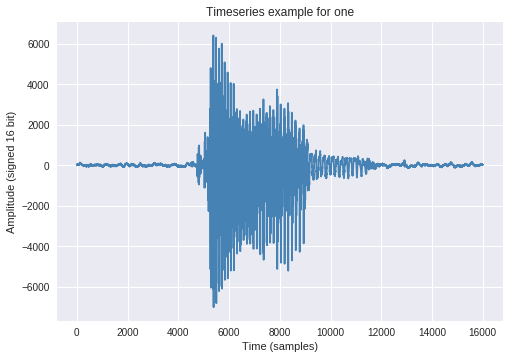

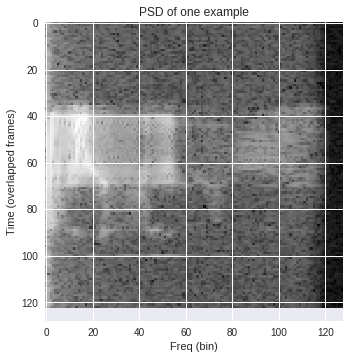

In [0]:
plt.plot(data_list[0], color='steelblue')
plt.title('Timeseries example for %s'%labels[0])
#plt.xlim(0, 3500)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (signed 16 bit)')
plt.figure()

# + 1 to avoid log of 0
log_freq = 20 * np.log(np.abs(stft(data_list[0])) + 1)
print(log_freq.shape)
plt.imshow(log_freq, cmap='gray', interpolation=None)
plt.xlabel('Freq (bin)')
plt.ylabel('Time (overlapped frames)')
plt.ylim(log_freq.shape[1])
plt.title('PSD of %s example'%labels[0])

Melspectrogram

(126, 50)


Text(0.5, 1.0, 'PSD of one example')

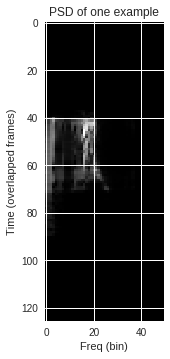

In [33]:
# + 1 to avoid log of 0
mel_freq = calculate_melsp(data_list[0])
mel_freq = mel_freq.T
print(mel_freq.shape)
plt.imshow(mel_freq, cmap='gray', interpolation=None)
plt.xlabel('Freq (bin)')
plt.ylabel('Time (overlapped frames)')
#plt.ylim(log_freq.shape[1])
plt.title('PSD of %s example'%labels[0])

MFCC

(25, 126)


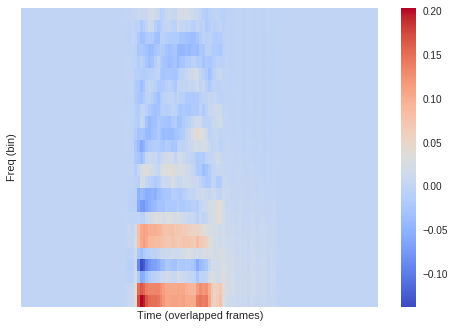

In [39]:
mfcc_freq = librosa.feature.mfcc( S=calculate_melsp(data_list[0]), n_mfcc=25 )
#mfcc_freq = mfcc_freq.T
print(mfcc_freq.shape)
librosa.display.specshow(mfcc_freq, sr=16000)# x_axis='time'
plt.colorbar()
plt.ylabel('Freq (bin)')
plt.xlabel('Time (overlapped frames)')
#plt.ylim(log_freq.shape[1])
#plt.title('PSD of %s example'%labels[0])
plt.show()

Text(0, 0.5, 'Amplitude')

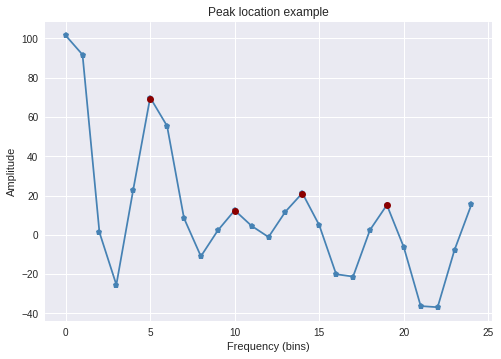

In [35]:
plot_data = mfcc_freq[:, 60]*1000
values, locs = peakfind(plot_data, n_peaks=6)
fp = locs[values > -1]
fv = values[values > -1]
plt.plot(plot_data[0:100], color='steelblue', marker='p')
plt.plot(fp, fv, marker='o', color='darkred', linestyle='None')
plt.title('Peak location example')
plt.xlabel('Frequency (bins)')
plt.ylabel('Amplitude')

In [40]:
#This processing (top freq peaks) only works for single speaker case... need better features for multispeaker!
#MFCC (or deep NN/automatic feature extraction) could be interesting
all_obs = []
for i in range(data_list.shape[0]):
    d = np.abs(stft(data_list[i]))
    n_dim = 6
    obs = np.zeros((n_dim, d.shape[0]))
    for r in range(d.shape[0]):
        _, t = peakfind(d[r, :], n_peaks=n_dim)
        obs[:, r] = t.copy()
    if i % 10 == 0:
        print("Processed obs %s" % i)
    all_obs.append(obs)
    
all_obs = np.atleast_3d(all_obs)

Processed obs 0
Processed obs 10
Processed obs 20
Processed obs 30
Processed obs 40
Processed obs 50
Processed obs 60
Processed obs 70
Processed obs 80
Processed obs 90


In [41]:
all_obs.shape

(100, 6, 123)

MFCC

In [45]:
all_obs = []
for i in range(data_list.shape[0]):
    d = librosa.feature.mfcc( S=calculate_melsp(data_list[i]), n_mfcc=25 )#calculate_melsp(data_list[i])
    d = d.T
    n_dim = 6
    obs = np.zeros((n_dim, d.shape[0]))
    for r in range(d.shape[0]):
        _, t = peakfind(d[r, :], n_peaks=n_dim)
        obs[:, r] = t.copy()
    if i % 10 == 0:
        print("Processed obs %s" % i)
    all_obs.append(obs)
    
all_obs = np.atleast_3d(all_obs)

Processed obs 0
Processed obs 10
Processed obs 20
Processed obs 30
Processed obs 40
Processed obs 50
Processed obs 60
Processed obs 70
Processed obs 80
Processed obs 90


In [46]:
all_obs.shape

(100, 6, 126)

GMM-HMM Bop
-----------

An implementation of a GMM-HMM is shown below. This code is also available as a [gist](https://gist.github.com/kastnerkyle/75483d51641a0c03bf7c), and any improvements I make will show up there.

This algorithm is fairly complex, and a good summary can be seen [here, Brown](http://cs.brown.edu/research/ai/dynamics/tutorial/Documents/HiddenMarkovModels.html) and [here, Moore](http://www.autonlab.org/tutorials/hmm.html). This implementation does *not* have any Viterbi backtracking - since my only interest (for now) is in speech classification, only Baum-Welch and Forward-Backward portions of the GMM-HMM are necessary.

HMMs can do do three primary tasks:

1. State Estimation $P(S | O)$ - can be useful *if* you have prior info about what states mean and create the state probabilities yourself.
2. Path Estimation - given observations, what is the most likely "state path"? Not useful in our case, and not even implemented here!
3. Maximum Likelihood Estimation $P(O | \lambda)$ - learn the HMM parameters $\lambda$ which maximize the probability of observations. This is the primary method we will use.

To train the HMM, we use the Baum-Welch algorithm. There are many, many resources on this algorithm and I will not regurgitate here. Implementing this HMM was fairly tricky, and I highly recommend using a library unless you are interested in a "learning experience".

This code uses requires scipy 0.14 for the multivariate_normal density.

In [47]:
import scipy.stats as st
import numpy as np

class gmmhmm:
    #This class converted with modifications from https://code.google.com/p/hmm-speech-recognition/source/browse/Word.m
    def __init__(self, n_states):
        self.n_states = n_states
        self.random_state = np.random.RandomState(0)
        
        #Normalize random initial state
        self.prior = self._normalize(self.random_state.rand(self.n_states, 1))
        self.A = self._stochasticize(self.random_state.rand(self.n_states, self.n_states))
        
        self.mu = None
        self.covs = None
        self.n_dims = None
           
    def _forward(self, B):
        log_likelihood = 0.
        T = B.shape[1]
        alpha = np.zeros(B.shape)
        for t in range(T):
            if t == 0:
                alpha[:, t] = B[:, t] * self.prior.ravel()
            else:
                alpha[:, t] = B[:, t] * np.dot(self.A.T, alpha[:, t - 1])
         
            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood = log_likelihood + np.log(alpha_sum)
        return log_likelihood, alpha
    
    def _backward(self, B):
        T = B.shape[1]
        beta = np.zeros(B.shape);
           
        beta[:, -1] = np.ones(B.shape[0])
            
        for t in range(T - 1)[::-1]:
            beta[:, t] = np.dot(self.A, (B[:, t + 1] * beta[:, t + 1]))
            beta[:, t] /= np.sum(beta[:, t])
        return beta
    
    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.n_states, obs.shape[1]))
        for s in range(self.n_states):
            #Needs scipy 0.14
            np.random.seed(self.random_state.randint(1))
            B[s, :] = st.multivariate_normal.pdf(
                obs.T, mean=self.mu[:, s].T, cov=self.covs[:, :, s].T)
            #This function can (and will!) return values >> 1
            #See the discussion here for the equivalent matlab function
            #https://groups.google.com/forum/#!topic/comp.soft-sys.matlab/YksWK0T74Ak
            #Key line: "Probabilities have to be less than 1,
            #Densities can be anything, even infinite (at individual points)."
            #This is evaluating the density at individual points...
        return B
    
    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)
    
    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)
    
    def _em_init(self, obs):
        #Using this _em_init function allows for less required constructor args
        if self.n_dims is None:
            self.n_dims = obs.shape[0]
        if self.mu is None:
            subset = self.random_state.choice(np.arange(self.n_dims), size=self.n_states, replace=False)
            self.mu = obs[:, subset]
        if self.covs is None:
            self.covs = np.zeros((self.n_dims, self.n_dims, self.n_states))
            self.covs += np.diag(np.diag(np.cov(obs)))[:, :, None]
        return self
    
    def _em_step(self, obs): 
        obs = np.atleast_2d(obs)
        B = self._state_likelihood(obs)
        T = obs.shape[1]
        
        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)
        
        xi_sum = np.zeros((self.n_states, self.n_states))
        gamma = np.zeros((self.n_states, T))
        
        for t in range(T - 1):
            partial_sum = self.A * np.dot(alpha[:, t], (beta[:, t] * B[:, t + 1]).T)
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:, t] * beta[:, t]
            gamma[:, t] = self._normalize(partial_g)
              
        partial_g = alpha[:, -1] * beta[:, -1]
        gamma[:, -1] = self._normalize(partial_g)
        
        expected_prior = gamma[:, 0]
        expected_A = self._stochasticize(xi_sum)
        
        expected_mu = np.zeros((self.n_dims, self.n_states))
        expected_covs = np.zeros((self.n_dims, self.n_dims, self.n_states))
        
        gamma_state_sum = np.sum(gamma, axis=1)
        #Set zeros to 1 before dividing
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)
        
        for s in range(self.n_states):
            gamma_obs = obs * gamma[s, :]
            expected_mu[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]
            partial_covs = np.dot(gamma_obs, obs.T) / gamma_state_sum[s] - np.dot(expected_mu[:, s], expected_mu[:, s].T)
            #Symmetrize
            partial_covs = np.triu(partial_covs) + np.triu(partial_covs).T - np.diag(partial_covs)
        
        #Ensure positive semidefinite by adding diagonal loading
        expected_covs += .01 * np.eye(self.n_dims)[:, :, None]
        
        self.prior = expected_prior
        self.mu = expected_mu
        self.covs = expected_covs
        self.A = expected_A
        return log_likelihood
    
    def fit(self, obs, n_iter=15):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)
        if len(obs.shape) == 2:
            for i in range(n_iter):
                self._em_init(obs)
                log_likelihood = self._em_step(obs)
        elif len(obs.shape) == 3:
            count = obs.shape[0]
            for n in range(count):
                for i in range(n_iter):
                    self._em_init(obs[n, :, :])
                    log_likelihood = self._em_step(obs[n, :, :])
        return self
    
    def transform(self, obs):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)
        if len(obs.shape) == 2:
            B = self._state_likelihood(obs)
            log_likelihood, _ = self._forward(B)
            return log_likelihood
        elif len(obs.shape) == 3:
            count = obs.shape[0]
            out = np.zeros((count,))
            for n in range(count):
                B = self._state_likelihood(obs[n, :, :])
                log_likelihood, _ = self._forward(B)
                out[n] = log_likelihood
            return out

if __name__ == "__main__":
    rstate = np.random.RandomState(0)
    t1 = np.ones((4, 40)) + .001 * rstate.rand(4, 40)
    t1 /= t1.sum(axis=0)
    t2 = rstate.rand(*t1.shape)
    t2 /= t2.sum(axis=0)
    
    m1 = gmmhmm(2)
    m1.fit(t1)
    m2 = gmmhmm(2)
    m2.fit(t2)
    
    m1t1 = m1.transform(t1)
    m2t1 = m2.transform(t1)
    print("Likelihoods for test set 1")
    print("M1:", m1t1)
    print("M2:", m2t1)
    print("Prediction for test set 1")
    print("Model", np.argmax([m1t1, m2t1]) + 1)
    print()
    
    m1t2 = m1.transform(t2)
    m2t2 = m2.transform(t2)
    print("Likelihoods for test set 2")
    print("M1:", m1t2)
    print("M2:", m2t2)
    print("Prediction for test set 2")
    print("Model", np.argmax([m1t2, m2t2]) + 1)

Likelihoods for test set 1
M1: 221.38828575112734
M2: 165.27280230776495
Prediction for test set 1
Model 1

Likelihoods for test set 2
M1: 33.19459421485196
M2: 59.15274753052998
Prediction for test set 2
Model 2


Still Peaking
-------------

Once the peaks are detected for each frame, we have a 3 dimensional numpy array of size [numdatafiles, numpeaks, numframes] - in this case [105, 6, 216]. It is important that the observations be normalized in order to form probabilities, since the HMM expects to be trained on state probabilities. What does this mean?

For each sample, we have extracted a number of frames over time, and each frame has its own set of peaks. We divide each frame by the sum of all peaks in the frame (axis 0 of all_obs[n], or axis 1 of all_obs), and form a "state probability" for each frame in our dataset. In essence, we are creating 6 states, where the highest peak in a frame is state 1, second highest state 2, etc. for each FFT frame. 

This representation shows the "spread" of the peaks - if all the peaks are close together, each one will have about the same probability, while peaks that are in a more unique distribution should take on a more unique fingerprint. An extreme case would be 3 low frequency peaks, and 3 high - this would result in very low state probabilities for the low frequency peaks, and very high state probabilities for the high frequency peaks. Since the HMM attempts to learn transition probabilities between frames, this is a decent way to represent speech for HMMs.

各フレームについてピークが検出されると、サイズが[numdatafiles、numpeaks、numframes]、この場合は[105、6、216]の3次元のでこぼこの配列ができます。 ＨＭＭは状態確率に関して訓練されることを期待するので、確率を形成するために観測値を正規化することが重要である。これは何を意味するのでしょうか？

各サンプルについて、我々は経時的に多数のフレームを抽出し、そして各フレームはそれ自身のピークのセットを有する。各フレームをフレーム内のすべてのピークの合計（all_obs [n]の軸0、またはall_obsの軸1）で割り、データセット内の各フレームの "状態確率"を形成します。本質的に、我々は６つの状態を作り出しており、そこではフレーム内の最も高いピークは各ＦＦＴフレームについて状態１、２番目に高い状態２などである。

この表現は、ピークの「広がり」を示しています。すべてのピークが互いに接近している場合、各ピークはほぼ同じ確率になりますが、よりユニークな分布にあるピークはよりユニークなフィンガープリントを帯びるはずです。極端な場合は、3つの低周波数ピークと3つの高周波数です。これは、低周波数ピークでは非常に低い状態確率、高周波数ピークでは非常に高い状態確率になります。 ＨＭＭはフレーム間の遷移確率を学習しようと試みるので、これはＨＭＭのための音声を表すための適当な方法である。

In [48]:
from sklearn.model_selection import train_test_split

for n,i in enumerate(all_obs):
    all_obs[n] /= all_obs[n].sum(axis=0)
X_train, X_test, y_train, y_test = train_test_split(all_obs, all_labels, test_size=0.1, random_state=1)

print('Size of training matrix:', X_train.shape)
print('Size of testing matrix:', X_test.shape)

Size of training matrix: (90, 6, 126)
Size of testing matrix: (10, 6, 126)


To predict words, we need to train 7 separate GMM-HMM models, one for each word. We will then feed the features for a test sample into each, choosing the word associated with the GMM-HMM having the highest output likelihood. This maximum likelihood estimate is our best guess for what word was spoken.

In [49]:
for iii in [6]:

    ys = set(all_labels)

    ms = [gmmhmm(iii) for y in ys]
    _ = [m.fit(X_train[y_train == y, :, :]) for m, y in zip(ms, ys)]
    ps = [m.transform(X_test) for m in ms]
    res = np.vstack(ps)
    predicted_labels = np.argmax(res, axis=0)
    missed = (predicted_labels != y_test)
    print('Test accuracy: %d, %.2f percent' % (iii, 100 * (1 - np.mean(missed))))

Test accuracy: 6, 20.00 percent


It seems that this classifier does decently. Let's look at a confusion matrix for what words were incorrect, to see if there is any unusual pattern in the misclassifications.

Text(0.5, 0, 'Predicted label')

<Figure size 1440x1440 with 0 Axes>

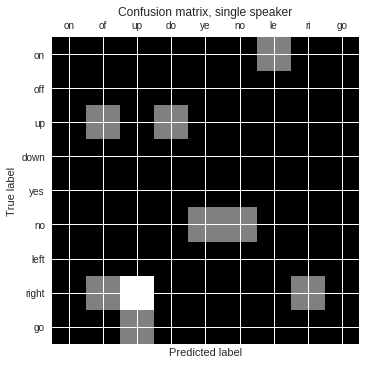

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(20, 20))
plt.matshow(cm, cmap='gray')
ax = plt.gca()
_ = ax.set_xticklabels([" "] + [l[:2] for l in spoken])
_ = ax.set_yticklabels([" "] + spoken)
plt.title('Confusion matrix, single speaker')
plt.ylabel('True label')
plt.xlabel('Predicted label')

Though the confusion matrix doesn't provide much insight, it is good to see a "real" example of using HMMs to do single speaker speech recognition.

kk

# Speech Data Set